#### downgrade scipy if smm complained

In [2]:
# import sys
# !{sys.executable} -m pip install autograd

# !{sys.executable} -m pip install seaborn

# !{sys.executable} -m pip install ssm
# import sys
# !{sys.executable} -m pip install scipy==1.2.1

In [3]:
from scipy.linalg import block_diag
import autograd.numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ssm

%matplotlib inline

## all old stuff

In [194]:
# loading and dataset functions

import pathlib
import os.path
import csv
import numpy as np

""" FILE NAMES """
# Quality of recordings for a given active neuron
f_quality = "clusters._phy_annotation.npy"
# Which neuron was detected by which channel:
f_channels = "clusters.peakChannel.npy"
# Active neurons indices:
f_clusters = "spikes.clusters.npy"
# Info about channels <-> brain areas:
f_areas = "channels.brainLocation.tsv"

# Time of spike:
f_times = "spikes.times.npy"
# Times of visual stimulations for each trial
f_visual = "trials.visualStim_times.npy"
# Times of auditory cue for each trial
f_cue = "trials.goCue_times.npy"


# Info about the trial time intervals:
f_trials = "trials.intervals.npy"
# Info about the trials used:
f_trials_idx = "trials.included.npy"

# Location of the project
project_path = pathlib.Path().absolute()


""" LOADING FUNCTIONS """


def load_visual_stim_times(recording_name):
    # Returns a vector of length n_trials. Each value tells the time at which the stimulus was played for a given trial
    data_path = os.path.join(project_path, 'data', recording_name)
    visual_times_file = os.path.join(data_path, f_visual)
    visual_times = np.load(visual_times_file)
    visual_times = visual_times.reshape(len(visual_times))
    return visual_times


def load_cue_times(recording_name):
    # Returns a vector of length n_trials. Each value tells the time at which the cue was played for a given trial
    data_path = os.path.join(project_path, 'data', recording_name)
    cue_times = os.path.join(data_path, f_cue)
    cue_times = np.load(cue_times)
    cue_times = cue_times.reshape(len(cue_times))
    return cue_times


def load_neuron_regions(recording_name):
    # Returns a vector of length n_neurons. Each value tells the brain area of the given neuron
    data_path = os.path.join(project_path, 'data', recording_name)

    # Load info about neuron's channel
    channels_file = os.path.join(data_path, f_channels)
    neurons_2_channels = np.load(channels_file)
    neurons_2_channels = neurons_2_channels.reshape(len(neurons_2_channels))

    # Load info about channel's regions
    areas_file = os.path.join(data_path, f_areas)
    reader = csv.reader(open(areas_file, "r"), delimiter="\t")
    regions_2_channels = np.array(list(reader))[:, 3]
    neurons_2_channels = neurons_2_channels.reshape(len(neurons_2_channels))
    neurons_2_channels = neurons_2_channels.astype(int)

    # Combine the information above to discover which region corresponds to each neuron
    neuron_2_regions = regions_2_channels[neurons_2_channels]
    return neuron_2_regions


def load_neuron_grades(recording_name):
    # Returns a vector of length n_neurons. Each value tells the grade (1=bad, 2=decent, 3=good) of the given neuron
    data_path = os.path.join(project_path, 'data', recording_name)
    grades_file = os.path.join(data_path, f_quality)
    neuron_2_grades = np.load(grades_file)
    neuron_2_grades = neuron_2_grades.reshape(len(neuron_2_grades))
    neuron_2_grades = neuron_2_grades.astype(int)
    return neuron_2_grades


def load_trial_intervals(recording_name, idx=None):
    # Returns a vector of length n_neurons. Each value tells the grade (1=bad, 2=decent, 3=good) of the given neuron
    data_path = os.path.join(project_path, 'data', recording_name)
    trials_file = os.path.join(data_path, f_trials)
    trials_indices_file = os.path.join(data_path, f_trials_idx)

    trials = np.load(trials_file)
    trials_indices = np.load(trials_indices_file)
    selected_trials = clean_trials(trials, trials_indices)

    if idx is not None:
        selected_trials = selected_trials[idx]

    return selected_trials


def load_spike_times(recording_name):
    # Returns a vector of length n_spikes. Each value tells the time at which the spike was recorded (in seconds)
    data_path = os.path.join(project_path, 'data', recording_name)
    spikes_file = os.path.join(data_path, f_times)
    spikes = np.load(spikes_file)
    spikes = spikes.reshape(len(spikes))
    return spikes


def load_spikes_2_neurons(recording_name):
    # Returns a vector of length n_spikes. Each value is the identifier of the neuron to which the spike belongs
    data_path = os.path.join(project_path, 'data', recording_name)
    neurons_file = os.path.join(data_path, f_clusters)
    spikes_2_neurons = np.load(neurons_file)
    spikes_2_neurons = spikes_2_neurons.reshape(len(spikes_2_neurons))
    spikes_2_neurons = spikes_2_neurons.astype(int)
    return spikes_2_neurons


""" DATA-SET FUNCTIONS """


def clean_trials(trial_intervals, included_trials):
    #   Remove trials that were not included
    #   INPUT: trial_intervals  - onset and offset timestamps of a N trials
    #          included_trials - boolean +1 included, 0 not included
    #
    idx = np.where(included_trials == 1)
    idx = idx[0]
    return trial_intervals[idx, :]


def select_neurons_by_region(recording_name, region):
    # Return a vector with the identifiers of all the neurons belonging to a given brain area
    neuron_2_regions = load_neuron_regions(recording_name)
    neuron_indices = np.where(np.char.equal(region, neuron_2_regions))[0]
    return neuron_indices


def select_neurons_by_grade(recording_name, minimum_grade):
    # Return a vector with the identifiers of all the neurons with score >= minimum_grade
    neuron_2_grades = load_neuron_grades(recording_name)
    neuron_indices = np.where(neuron_2_grades > minimum_grade)[0]
    return neuron_indices


def generate_spike_counts(recording_name, brain_region, minimum_grade, dt, t0, tf, firing_rates=False):
    # Selects the neuron belonging to a given brain region, and generates a data-set.
    # Returns: a matrix [n_neurons * n_time_steps] describing how many times each neuron spiked at a given time step
    # Arguments:
    # brain_region: the brain region we want to analyze
    # minimum_grade: the minimum score we accept to include a neuron in the data-set (1=bad, 2=decent, 3=good)
    # t0 = the initial time step (seconds)
    # tf = the final time step (seconds)
    # dt = the length of each time step (seconds)
    # firing_rates = if false, the returned values are spike counts. if true, it is firing rates

    # select the neurons based on brain region and score
    neuron_indices_1 = select_neurons_by_region(recording_name, brain_region)
    neuron_indices_2 = select_neurons_by_grade(recording_name, minimum_grade)
    neuron_indices = np.intersect1d(neuron_indices_1, neuron_indices_2)

    # load spikes and spike mappings
    spikes = load_spike_times(recording_name)
    spikes_2_neurons = load_spikes_2_neurons(recording_name)

    # generate the time steps sequence
    time_steps = np.arange(t0, tf, dt)
    n_time_bins = len(time_steps) - 1
    time_bins = time_steps[1:]

    n_neurons = len(neuron_indices)
    spike_counts = np.zeros((n_neurons, n_time_bins))

    for i, neuron_id in enumerate(neuron_indices):
        # for each neuron, retrieve its spikes
        neuron_spikes = spikes[spikes_2_neurons == neuron_id]

        # generate an histogram of spike counts
        [neuron_spike_counts, _] = np.histogram(neuron_spikes, time_steps)
        if firing_rates:
            neuron_spike_counts = neuron_spike_counts / dt
        spike_counts[i, :] = neuron_spike_counts

    return spike_counts, time_bins


In [176]:
# functions for selecting trials of choice

import pathlib
import os.path
import numpy as np



""" FILE NAMES """
# Interval of trials [onset, offset]
f_intervals = "trials.intervals.npy"
# Which trials were included [boolean]
f_included = "trials.included.npy"
# Timing of visual stimulation onset
f_visStim_times = "trials.visualStim_times.npy"
# Timing of the auditory go cue
f_cue_times = "trials.goCue_times.npy"
# Response choice: -1 for right, +1 for left, 0 for no-go
f_choice = "trials.response_choice.npy"
# Response time
f_response_times = "trials.response_times.npy"
# Feedback time 
f_feedback_times = "trials.feedback_times.npy"
# Feedback type:  -1 for white noise (miss), +1 for water reward (hit)
f_feedback_types = "trials.feedbackType.npy"


# Location of the project
project_path = pathlib.Path().absolute()


filenames = list([f_intervals, f_included, f_visStim_times, f_cue_times, f_choice, f_response_times, f_feedback_times, f_feedback_types])


def load_trial_files (recording_name):
    data_path = os.path.join(project_path, 'data', recording_name)
    alldata = []
    for filename in filenames:
        file = os.path.join(data_path, filename)
        data = np.load(file)
        alldata.append(data)
        
    trials = {
        'interval': alldata[0],
        'included': alldata[1],
        'visStim_times': alldata[2],
        'cue_times': alldata[3],
        'choice': alldata[4],
        'response_time': alldata[5],
        'feedback_times': alldata[6],
        'feedback_types': alldata[7],
    }
    
    return trials
    

def extract_clean_trials (recording_name):
#   Remove trials that were not included
#   INPUT: trial_intervals  - onset and offset timestamps of a N trials
#          included_trials - boolean +1 included, 0 not included
  trials = load_trial_files (recording_name)
    
  included_trials = trials['included']
  idx = np.where(included_trials == 1 )
  idx = idx[0]
  
  # Undate trials [dictionary]
  trials['interval'] = trials['interval'][idx,:]
  trials['included'] = trials['included'][idx,:]
  trials['visStim_times'] = trials['visStim_times'][idx,:]
  trials['cue_times'] = trials['cue_times'][idx,:]
  trials['choice'] = trials['choice'][idx,:]
  trials['response_time'] = trials['response_time'][idx,:]
  trials['feedback_times'] = trials['feedback_times'][idx,:]
  trials['feedback_types'] = trials['feedback_types'][idx,:]
      
  
  return trials




In [177]:
# function for mapping best colors scheme 

import numpy as np
from sympy.utilities.iterables import multiset_permutations


def map_states(n_states, sequence1, sequence2):
    # Maps the best permutation of sequence 2 to sequence 1
    all_states = range(n_states)

    min_T = np.min([len(sequence1), len(sequence2)])
    sequence1 = sequence1[:min_T]
    sequence2 = sequence2[:min_T]

    best_score = -np.inf
    best_mapping = sequence2
    for permutation in multiset_permutations(all_states):
        permutation = np.array(permutation)
        remapped_sequence2 = permutation[sequence2]
        score = np.sum(remapped_sequence2 == sequence1)
        if score > best_score:
            best_score = score
            best_mapping = remapped_sequence2
    return best_mapping


In [178]:
# plotting functions

from matplotlib import pyplot as plt
import matplotlib.patches as patches
import numpy as np


def plot_psths(dataset, time_bins, title, visual_time, cue_time, feedback_time):
    plt.imshow(dataset, cmap='binary', aspect='auto')
    plt.title(title)
    plt.ylabel('neurons')
    plt.xlabel('time (ms)')

    x_ticks = [0, len(time_bins)-1]
    x_labels = (time_bins[x_ticks] - time_bins[0]) * 1000
    plt.xticks(x_ticks, x_labels.astype(int))

    visual_time_bin = np.where(visual_time < time_bins)[0][0]
    plt.axvline(visual_time_bin, color='r')

    cue_time_bin = np.where(cue_time < time_bins)[0][0]
    plt.axvline(cue_time_bin, color='g')

    feedback_time_bin = np.where(feedback_time < time_bins)[0][0]
    plt.axvline(feedback_time_bin, color='k')

    plt.legend(['visual', 'cue', 'feedback'])


def add_states_2_psth(fig, states, colors, n_neurons):
    # Create a Rectangle patch
    previous_state_change = 0
    state_changes = np.where(np.diff(states))[0]
    for state_change in state_changes:

        state = states[previous_state_change]
        c = colors[state]

        state_dt = state_change - previous_state_change
        rect = patches.Rectangle((previous_state_change, 0), state_dt, n_neurons, edgecolor='none', facecolor=c, alpha=0.2)
        fig.add_patch(rect)
        previous_state_change = state_change

    state = states[previous_state_change]
    c = colors[state]

    state_dt = len(states) - previous_state_change
    rect = patches.Rectangle((previous_state_change, 0), state_dt, n_neurons, edgecolor='none', facecolor=c, alpha=0.2)
    fig.add_patch(rect)




In [179]:
# main

# Experimental Parameters
recording_name = 'Cori_2016-12-14'
brain_region = 'ACA'
neuron_min_score = 2

# Model Parameters
bin_dt = 0.01  # seconds
pre_stim_dt = 0.5 # seconds
post_resp_dt = 0.5 # seconds
n_compoments = 5
colors = ['r', 'g', 'b', 'y', 'm', 'c']

# Choose trials
trials = extract_clean_trials(recording_name)
conditioned_trials = np.where(trials['choice'] == 0)[0]

# Run the fit
# plt.figure()
n_trials = 8
for i in range(7,n_trials):
#     fig = plt.subplot(1, n_trials, i + 1)

    # Load time pointers for the given trial
    trial = conditioned_trials[i]
    visual_time = trials['visStim_times'][trial]
    cue_time = trials['cue_times'][trial]
    feedback_time = trials['feedback_times'][trial]

    # generate the spike count histograms
    t0 = visual_time - pre_stim_dt
    tf = feedback_time + post_resp_dt
    [dataset, time_bins] = generate_spike_counts(recording_name, brain_region, neuron_min_score, bin_dt, t0, tf)
    (n_neurons, n_bins) = dataset.shape

#     # Create a hmm model
#     model = hmm.GaussianHMM(n_components=n_compoments, n_iter=1000)
#     model.fit(dataset.T)
#     [logprob, states] = model.decode(dataset.T)

    # Find the best mapping of the state sequences
#     if i == 0:
#         states_trial0 = states
#     else:
#         states = map_states(n_compoments, states_trial0, states)

#     # Plot
#     title = brain_region + ' trial#' + str(trial)
#     plot_psths(dataset, time_bins, title, visual_time, cue_time, feedback_time)
#     add_states_2_psth(fig, states, colors, n_neurons)

# plt.show()

## step by step smm

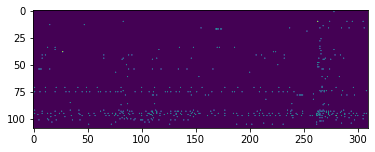

In [180]:
plt.imshow(dataset)

In [181]:
dataset.shape[0]

109

In [182]:
dataset.shape[1]

310

In [183]:
type(dataset[10][10])

numpy.float64

In [184]:
num_states = 3

In [185]:
num_neurons = dataset.shape[0]
num_neurons

109

In [186]:
dataset = dataset.astype(int)

In [187]:
from scipy.linalg import block_diag
import autograd.numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ssm


In [188]:
# Create our HMM
simple_hmm = ssm.HMM(num_states,
                     num_neurons,
                     observations="poisson",
                     transitions="standard")


In [189]:
lls = simple_hmm.fit(dataset.T)

In [190]:
states_ = simple_hmm.most_likely_states(dataset.T)

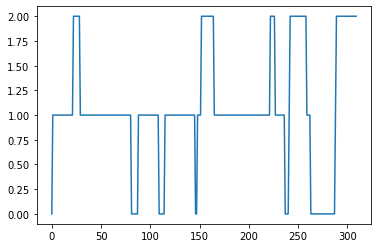

In [192]:
plt.plot(states_)

In [195]:
post_trial = 7

trial = conditioned_trials[post_trial]
visual_time = trials['visStim_times'][trial]
cue_time = trials['cue_times'][trial]
feedback_time = trials['feedback_times'][trial]

t0 = visual_time - pre_stim_dt
tf = feedback_time + post_resp_dt
[dataset, time_bins] = generate_spike_counts(recording_name, brain_region, neuron_min_score, bin_dt, t0, tf)
(n_neurons, n_bins) = dataset.shape

post_dataset = dataset
post_dataset = post_dataset.astype(int)

In [196]:
posterior = simple_hmm.filter(post_dataset.T)

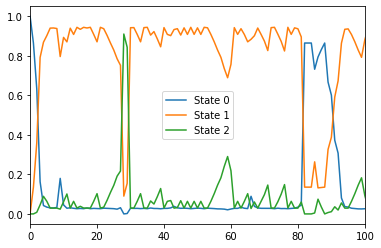

In [198]:
for i in range(num_states):
    plt.plot(posterior[:,i], label="State %d" % i)
    plt.xlim(0,100)
plt.legend()
